In [19]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345 # global seed for reproducibility

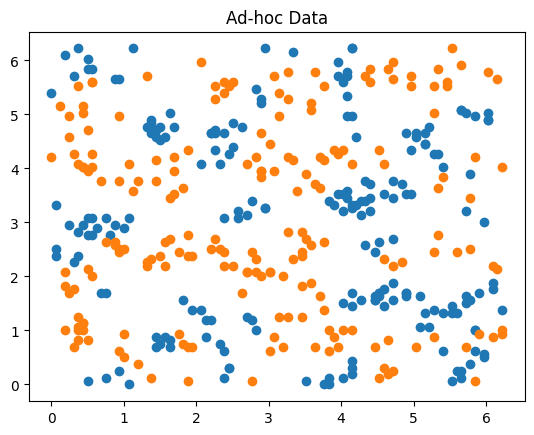

In [23]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=200,
    test_size=50,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)

In [24]:
train_features

array([[0.50265482, 0.06283185],
       [2.51327412, 4.83805269],
       [2.57610598, 3.20442451],
       [1.38230077, 4.64955713],
       [5.84336234, 1.00530965],
       [4.52389342, 1.63362818],
       [5.71769863, 5.02654825],
       [5.27787566, 4.27256601],
       [4.96371639, 4.33539786],
       [2.26194671, 4.71238898],
       [2.38761042, 3.0787608 ],
       [5.59203492, 0.25132741],
       [3.83274304, 0.        ],
       [6.09468975, 1.75929189],
       [0.87964594, 5.65486678],
       [4.58672527, 3.51858377],
       [0.56548668, 5.84336234],
       [4.33539786, 2.57610598],
       [4.46106157, 2.45044227],
       [4.27256601, 1.57079633],
       [2.136283  , 0.87964594],
       [2.07345115, 4.08407045],
       [1.57079633, 4.58672527],
       [2.38761042, 0.62831853],
       [3.76991118, 0.        ],
       [0.56548668, 3.0787608 ],
       [4.1469023 , 6.22035345],
       [4.52389342, 2.63893783],
       [5.02654825, 4.64955713],
       [4.90088454, 1.69646003],
       [5.

θ, ['θ[0]']


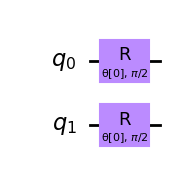

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Separate the dataset into features (X) and target label (y)
y = train_labels
X = train_features

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Set parameters for the quantum feature map
feature_dimension = 2  # Number of features used in the quantum feature map
reps = 2  # Number of repetitions of the feature map circuit
entanglement = 'linear'  # Type of entanglement in the quantum circuit

# Define a custom rotational layer for the quantum feature map
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
training_params = ParameterVector("θ", 1)
print(training_params)
fm0 = QuantumCircuit(feature_dimension)
for qubit in range(feature_dimension):
    fm0.ry(training_params[0], qubit)

fm0.decompose().draw(output="mpl", style="clifford", fold=20)

In [22]:
training_params._params

[ParameterVectorElement(θ[0])]

In [32]:
training_params[0]

ParameterVectorElement(θ[0])

In [26]:
from uuid import uuid4, UUID

root_uuid = uuid4()
root_uuid_int = root_uuid.int
root_uuid, root_uuid_int, UUID(int=root_uuid_int + 0)

(UUID('a84b5230-805b-4061-a01b-45e5afcf453a'),
 223701392556519676380685412098533967162,
 UUID('a84b5230-805b-4061-a01b-45e5afcf453b'))

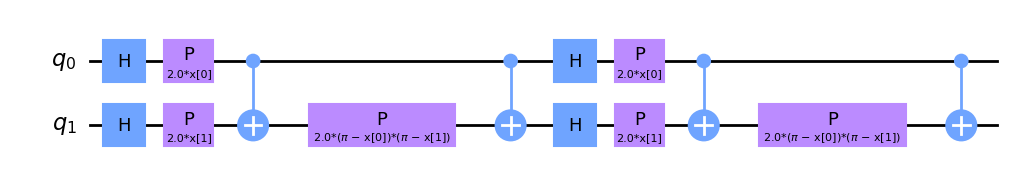

In [46]:
# Use ZZFeatureMap to represent input data
from qiskit.circuit.library import ZZFeatureMap
fm1 = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement=entanglement)
fm1.decompose().draw(output="mpl", style="clifford", fold=20)

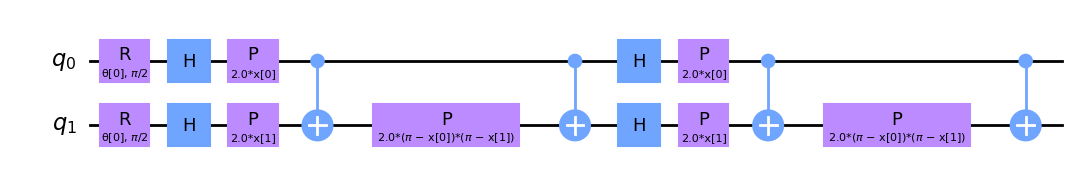

In [41]:


# Compose the custom rotational layer with the ZZFeatureMap to create the feature map
fm = fm0.compose(fm1)

fm.decompose().draw(output="mpl", style="clifford", fold=20)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


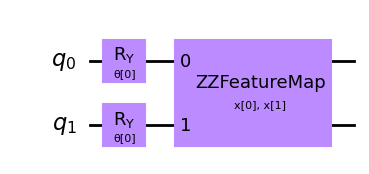

In [38]:
# Initialize the Sampler, a Qiskit primitive for sampling from quantum circuits
from qiskit.primitives import Sampler
sampler = Sampler()

# Set up the ComputeUncompute fidelity object for quantum kernel estimation
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
fidelity = ComputeUncompute(sampler=sampler)

# Instantiate the quantum kernel with the feature map and training parameters
quant_kernel = TrainableFidelityQuantumKernel(fidelity=fidelity, feature_map=fm, training_parameters=training_params)

In [40]:


# Callback class for tracking optimization progress
class QKTCallback:
    # Callback wrapper class
    def __init__(self):
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        #Capture callback data for analysis
        for i, x in enumerate([x0, x1, x2, x3, x4]):
            self._data[i].append(x)

    def get_callback_data(self):
        #Get captured callback data
        return self._data

    def clear_callback_data(self):
        #Clear captured callback data
        self._data = [[] for i in range(5)]

# Setup and instantiate the optimizer for the quantum kernel
from qiskit_algorithms.optimizers import SPSA
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.01, perturbation=0.05)

# Quantum Kernel Trainer (QKT) for optimizing the kernel parameters
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2]
)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_ = pca.fit_transform(X)

# print(X_)

print("Training")

# Train the quantum kernel with the reduced dataset
qka_results = qkt.fit(X_, y)
print(qka_results)
optimized_kernel = qka_results.quantum_kernel

print("Training complete")

# Use the quantum-enhanced kernel in a Quantum Support Vector Classifier (QSVC)
from qiskit_machine_learning.algorithms import QSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
qsvc = QSVC(quantum_kernel=optimized_kernel)
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), qsvc)

# Evaluate the performance of the model using cross-validation
from sklearn.model_selection import cross_val_score
cv = cross_val_score(pipeline, X, y, cv=5, n_jobs=1)
mean_score = np.mean(cv)

print(mean_score)

Training
{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 1.6476678824357232},
    'optimal_point': array([1.64766788]),
    'optimal_value': 327.8928065961118,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x140e76ad0>}
Training complete
0.605


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_labels)

# Quantum feature map setup
feature_dimension = 2
reps = 2
entanglement = 'linear'
training_params = ParameterVector("θ", 1)
fm0 = QuantumCircuit(feature_dimension)
for qubit in range(feature_dimension):
    fm0.ry(training_params[0], qubit)

fm1 = ZZFeatureMap(feature_dimension=feature_dimension, reps=reps, entanglement=entanglement)
fm = fm0.compose(fm1)

# Sampler and fidelity setup for quantum kernel
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
quant_kernel = TrainableFidelityQuantumKernel(fidelity=fidelity, feature_map=fm, training_parameters=training_params)

# Callback and optimizer for quantum kernel training
class QKTCallback:
    def __init__(self):
        self._data = [[] for i in range(5)]
    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        for i, x in enumerate([x0, x1, x2, x3, x4]):
            self._data[i].append(x)
    def get_callback_data(self):
        return self._data
    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.01, perturbation=0.05)
qkt = QuantumKernelTrainer(quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=[np.pi / 2])

# PCA transformation
pca = PCA(n_components=2)
X_ = pca.fit_transform(train_features)

print("Training QSVC")
qka_results = qkt.fit(X_, y)
optimized_kernel = qka_results.quantum_kernel
print("QSVC Training complete")

# Setup QSVC
qsvc = QSVC(quantum_kernel=optimized_kernel)
qsvc_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), qsvc)

# Evaluate QSVC
qscores = cross_val_score(qsvc_pipeline, train_features, y, cv=5, n_jobs=1)
qmean_score = np.mean(qscores)
print("QSVC Score:", qmean_score)

Training QSVC
QSVC Training complete
QSVC Score: 0.725
SVC Score: 0.375


In [12]:
qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 1.0


In [10]:
# Setup classical SVC
svc = SVC(kernel='rbf')
svc_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), svc)

# Evaluate classical SVC
cscores = cross_val_score(svc_pipeline, train_features, y, cv=5, n_jobs=1)
cmean_score = np.mean(cscores)
print("SVC Score:", cmean_score)

SVC Score: 0.475
